In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
class Value:

    def __init__(self, data, _children = (), op = "", label ="") -> None:
        self.data = data
        self._prev = set(_children)
        self._op = op
        self.grad = 0
        self.label = label
        self._backward = None

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)

        out = Value(self.data + other.data,(self, other), op="+")
        def backward():
            self.grad = 1 * out.grad
            other.grad = 1 * out.grad
            

        out._backward = backward

        return out
    
    def __sub__(self, other):
        if type(other) != type(Value):
            other = Value(other)
        return Value(self.data - other.data, (self,other), "-")
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        return Value(self.data * other.data, (self,other), "*")
    
    def __div__(self, other):
        if type(other) != type(Value):
            other = Value(other)
        return Value(self.data/other.data, (self,other), "/")
    
    def __pow__(self):
        return Value(self.data**2, (self,),"pow")
    
    def log(self):
        return Value(Math.log(self.data))
    
    def backward(self):
        self._backward()

    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
        

In [44]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
      for child in v._prev:
        build_topo(child)
      topo.append(v)

      
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      print(node)
      node._backward()

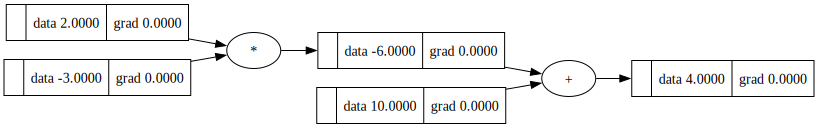

In [45]:
a = Value(-3)
b = Value(2)
c = Value(10)
d =  a*b + c

draw_dot(d)


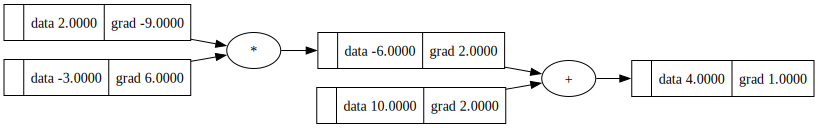

In [48]:
draw_dot(d)

In [47]:
d.backward()

Value(data=4)
Value(data=10)
Value(data=-6)
Value(data=2)
Value(data=-3)


In [ ]:
draw_dot(d)
